
Convallaria (*c. majalis*) acquired by Britta Schroth-Diez of the MPI-CBG Light Microscopy Facility,
denoised using structN2V. The data consists of 100 images of the same field of view, in order to
show structN2V denoising capabilities, we only select a single image as to not overestimate the
results by providing too much information to the network. The ground truth is obtained by averaging
all the images together.

In [1]:
# Imports necessary to execute the code
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pooch
import tifffile
from careamics import CAREamist
from careamics.config import create_n2v_configuration
from careamics.config.transformations import XYFlipModel
from careamics.utils import autocorrelation
from careamics.utils.metrics import scale_invariant_psnr
from PIL import Image

## Import the dataset

The dataset can be directly downloaded using the `careamics-portfolio` package, which
uses `pooch` to download the data.

In [2]:
# # instantiate data portfolio manage
# portfolio = PortfolioManager()

# # and download the data
# root_path = Path("./data")
# files = portfolio.denoising.Flower.download(root_path)

# create a folder for our data.
# TODO add it to the portfolio
path = Path("data")
if not path.exists():
    path.mkdir()

# download file
path_to_file = pooch.retrieve(
    "https://download.fht.org/jug/n2v/flower.tif",
    known_hash="08c2c77ae63d43d22631d69ae905ee695e8225cf9872183faf49bd0771e5b1a2",
    path=path,
)

### Data description

In [3]:
data_description = (
    "A single image of convallaria (*c. majalis*) acquired by Britta Schroth-Diez of "
    "the MPI-CBG Light Microscopy Facility."
)

## Visualize data and autocorrelation

Shape of the data (100, 1024, 1024)
Shape of the training data (1024, 1024)
Shape of the ground truth (1024, 1024)


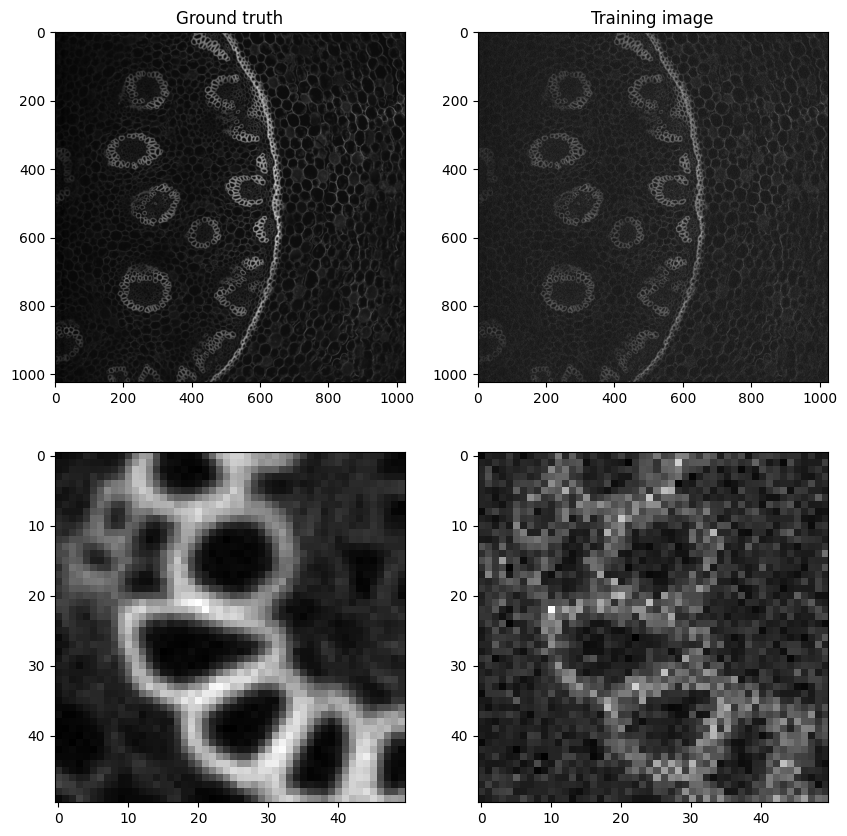

In [4]:
x_min, x_max = 580, 630
y_min, y_max = 380, 430

# load training and validation image and show them side by side
data = tifffile.imread(path_to_file)
print(f"Shape of the data {data.shape}")

train_image = data[50]
print(f"Shape of the training data {train_image.shape}")

gt_image = data.mean(axis=0)
print(f"Shape of the ground truth {gt_image.shape}")

# plot images
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(gt_image, cmap="gray")
ax[0, 0].set_title("Ground truth")

ax[0, 1].imshow(train_image, cmap="gray")
ax[0, 1].set_title("Training image")

ax[1, 0].imshow(gt_image[x_min:x_max, y_min:y_max], cmap="gray")

ax[1, 1].imshow(train_image[x_min:x_max, y_min:y_max], cmap="gray")

### Visualize autocorrelation

The autocorrelation shows a slight horizontal correlation.

Text(0.5, 1.0, 'Autocorrelation')

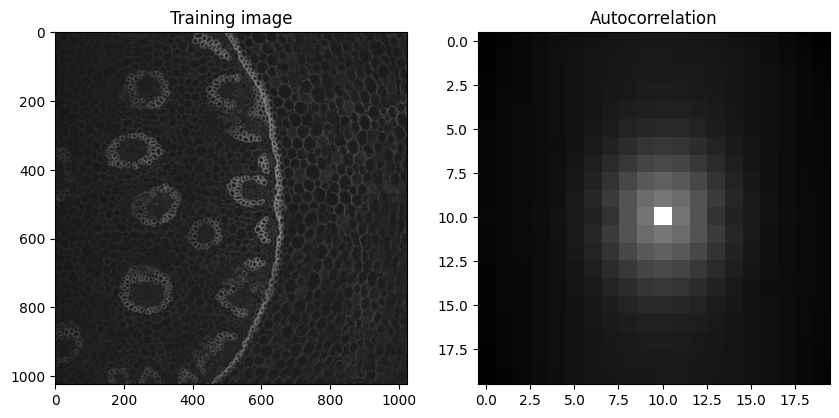

In [5]:
# compute autocorrelation
autocorr = autocorrelation(train_image)

# crop the correlation around (0, 0)
midpoint = train_image.shape[0] // 2
crop_size = 10
slices = (
    slice(midpoint - crop_size, midpoint + crop_size),
    slice(midpoint - crop_size, midpoint + crop_size),
)

# plot image and autocorrelation
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(train_image, cmap="gray")
ax[0].set_title("Training image")

ax[1].imshow(autocorr[slices], cmap="gray")
ax[1].set_title("Autocorrelation")

## Train with CAREamics

The easiest way to use CAREamics is to create a configuration and a `CAREamist`. 

### Create configuration

The configuration can be built from scratch, giving the user full control over the various
parameters available in CAREamics. However, a straightforward way to create a configuration
for a particular algorithm is to use one of the convenience functions.

To use structN2V, we simply add the relevant parameters to the configuration.

In [6]:
config = create_n2v_configuration(
    experiment_name="convallaria_structn2v",
    data_type="array",
    axes="YX",
    patch_size=(64, 64),
    batch_size=16,
    num_epochs=50,
    # structN2V parameters
    struct_n2v_axis="horizontal",
    struct_n2v_span=11,
    # disable augmentations because of the noise correlations
    augmentations=[],
)

# only use x-axis flip in augmentations
config.data_config.transforms.insert(
    0,
    XYFlipModel(flip_x=True, flip_y=False),
)

print(config)

{'algorithm_config': {'algorithm': 'n2v',
                      'loss': 'n2v',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 2,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 1,
                                'independent_channels': True,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 1},
                      'optimizer': {'name': 'Adam',
                                    'parameters': {'lr': 0.0001}}},
 'data_config': {'axes': 'YX',
                 'batch_size': 16,
                 'data_type': 'array',
                 'patch_size': [64, 64],
                 'transforms': [{'flip_x': True,
     

### Train

A `CAREamist` can be created using a configuration alone, and then be trained by using
the data already loaded in memory.

In [7]:
# instantiate a CAREamist
careamist = CAREamist(source=config)

# train
careamist.train(
    train_source=train_image,
)

No working directory provided. Using current working directory: /home/melisande.croft/Documents/Repos/careamics-examples/applications/n2v/2D.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40-16Q') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Computed dataset mean: [548.40212345], std: [99.30965717]
/localscratch/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/melisande.croft/Documents/Repos/careamics-examples/applications/n2v/2D/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | M

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/localscratch/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/localscratch/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/localscratch/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.














































































































































































































































































































Epoch 49: 100%|█| 15/15 [00:00<00:00, 49.49it/s, train_loss_step=0.57, val_loss=

`Trainer.fit` stopped: `max_epochs=50` reached.



poch 49: 100%|█| 15/15 [00:00<00:00, 40.08it/s, train_loss_step=0.57, val_loss=

Epoch 49: 100%|██████████| 15/15 [00:00<00:00, 19.30it/s, train_loss_step=0.335, val_loss=0.494, train_loss_epoch=0.46]


## Predict with CAREamics

Prediction is done with the same `CAREamist` used for training. Because the image is large
we predict using tiling.

In [8]:
prediction = careamist.predict(source=train_image, tile_size=(256, 256))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/localscratch/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |                                             | 0/? [00:00<?, ?it/s]

### Visualize the prediction

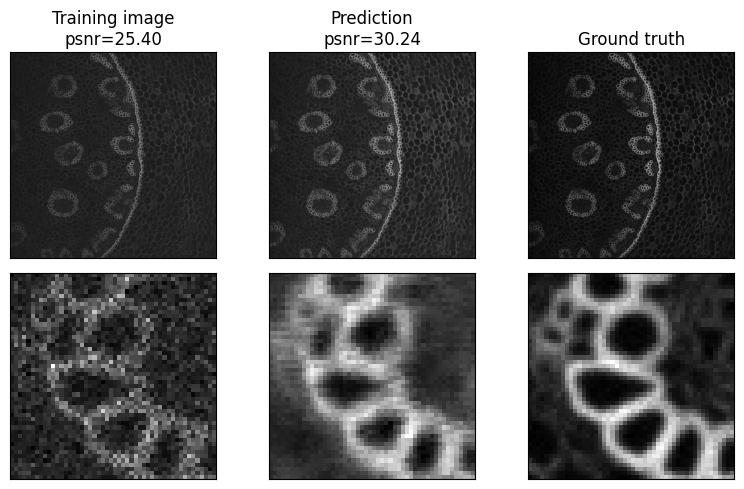

In [9]:
x_min, x_max = 580, 630
y_min, y_max = 380, 430

psnr_noisy = scale_invariant_psnr(gt_image, train_image)
pnsr_pred = scale_invariant_psnr(gt_image, prediction[0].squeeze())


# plot images
fig, ax = plt.subplots(2, 3, figsize=(8, 5))
ax[0, 0].imshow(train_image, cmap="gray")
ax[0, 0].set_title(f"Training image\npsnr={psnr_noisy:.2f}")
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

ax[0, 1].imshow(prediction[0].squeeze(), cmap="gray")
ax[0, 1].set_title(f"Prediction\npsnr={pnsr_pred:.2f}")
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

ax[0, 2].imshow(gt_image, cmap="gray")
ax[0, 2].set_title("Ground truth")
ax[0, 2].set_xticks([])
ax[0, 2].set_yticks([])

ax[1, 0].imshow(train_image[x_min:x_max, y_min:y_max], cmap="gray")
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

ax[1, 1].imshow(prediction[0].squeeze()[x_min:x_max, y_min:y_max], cmap="gray")
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

ax[1, 2].imshow(gt_image[x_min:x_max, y_min:y_max], cmap="gray")
ax[1, 2].set_xticks([])
ax[1, 2].set_yticks([])

fig.tight_layout()
plt.show()

### Compute metrics over the whole stack

In [10]:
predictions = careamist.predict(source=data, tile_size=(256, 256), axes="SYX")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                             | 0/? [00:00<?, ?it/s]

In [11]:
psnrs = np.zeros((len(predictions), 1))

for i, image in enumerate(predictions):
    psnrs[i] = scale_invariant_psnr(gt_image, image.squeeze())

print(f"PSNR: {psnrs.mean():.2f} +/- {psnrs.std():.2f}")

PSNR: 30.25 +/- 0.05


## Export the model

The model is automatically saved during training (the so-called `checkpoints`) and can 
be loaded back easily, but you can also export the model to the [BioImage Model Zoo](www.bioimage.io)
format.

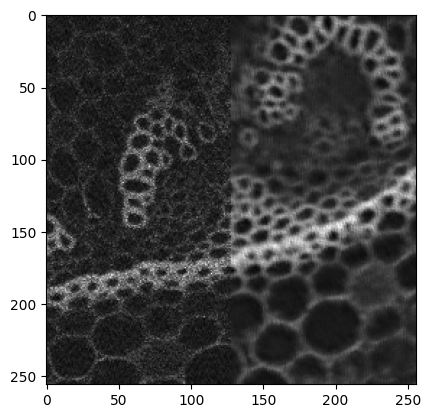

In [12]:
# create a cover image
x_start, width = 650, 256
y_start, height = 450, 256

# rotate images
rot_train = np.rot90(train_image, 3)
rot_pred = np.rot90(prediction[0].squeeze(), 3)

# create image
cover = np.zeros((height, width))

# normalize train and prediction
norm_train = (rot_train - rot_train.min()) / (rot_train.max() - rot_train.min())
norm_pred = (rot_pred - rot_pred.min()) / (rot_pred.max() - rot_pred.min())

# fill in halves
cover[:, : width // 2] = norm_train[
    y_start : y_start + height, x_start : x_start + width // 2
]
cover[:, width // 2 :] = norm_pred[
    y_start : y_start + height, x_start + width // 2 : x_start + width
]

# plot the single image
plt.imshow(cover, cmap="gray")

# save the image
im = Image.fromarray(cover * 255)
im = im.convert("L")
im.save("Convallaria_structN2V.jpeg")

In [13]:
general_description = (
    "This model is a UNet trained using the StructN2V algorithm to denoise images. "
    "(StructN2V is a variant of Noise2Void that can remove 1D structured noise, the "
    "main failure case of the original N2V) The training data consists of a single "
    "image of convallaria (*c. majalis*). The notebook used to train this model is "
    "available on the CAREamics documentation website at the following link: "
    "https://careamics.github.io/0.1/applications/structN2V/Convallaria/."
)
print(general_description)

This model is a UNet trained using the StructN2V algorithm to denoise images. (StructN2V is a variant of Noise2Void that can remove 1D structured noise, the main failure case of the original N2V) The training data consists of a single image of convallaria (*c. majalis*). The notebook used to train this model is available on the CAREamics documentation website at the following link: https://careamics.github.io/0.1/applications/structN2V/Convallaria/.


In [14]:
# Export the model
careamist.export_to_bmz(
    path_to_archive="convallaria_structn2v_model.zip",
    friendly_model_name="Convallaria_StructN2V",
    input_array=train_image.astype(np.float32),
    authors=[{"name": "CAREamics authors", "affiliation": "Human Technopole"}],
    general_description=general_description,
    data_description=data_description,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                             | 0/? [00:00<?, ?it/s]






2025-01-22 11:25:09.024 | Level 30 | bioimageio.spec.model.v0_5:_validate_documentation:2106 - documentation: No '# Validation' (sub)section found in /home/melisande.croft/.careamics/README.md.
2025-01-22 11:25:09.038 | INFO     | bioimageio.core._resource_tests:_test_model_inference:226 - starting 'Reproduce test outputs from test inputs (pytorch_state_dict)'
/localscratch/miniforge3/envs/careamics/lib/python3.10/site-packages/bioimageio/core/model_adapters/_pytorch_model_adapter.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arb